# Strokes Gained Statistics
“The strokes gained concept was initially developed by Professor Mark Broadie of Columbia University, utilizing ShotLink data that has been made available to academic institutions for research since 2007. Strokes gained is a better method for measuring performance because it compares a player's performance to the rest of the field and because it can isolate individual aspects of the game. Traditional golf statistics, such as greens in regulation and putts per green, are influenced by a player's performance on shots other than those being measured.”

(*Taken from an informational web-page of the PGA Tour*)

## Table of contents <a id="toc"></a>

1. [Data Wrangling](#wrangling)
    1. [Load Course Data](#loadcourse)
    1. [Load Game Data](#loadgame)
2. [Strokes Gained Categories](#categories)
    1. [Base Tables](#basetables)
    1. [Metrics](#metrics)
2. [Preparing Summaries](#summaries)
    1. [Per Category Summaries](#catsummaries)
    1. [Category Groups](#catgroups)
    1. [Classic Statistics](#classics)

## Data Wrangling <a name="wrangling"></a>
(<a href="#toc">back to ToC</a>)


In [1]:
import os
import re
import json
import datetime

### Load Course Data <a name="loadcourse"></a>
(<a href="#toc">back to ToC</a>)

Course data consists of meta data describing geo-coordinates and other aspects of every hole on the course.

In [2]:
courses_path = "/Users/npi/prg/python/strokesgained/strogain/static"
course_name = "Open.9"
meta_info_file = "course.json"

course_meta_path = os.path.join(courses_path, course_name, meta_info_file)

with open(course_meta_path, 'r') as f:
    course_meta = json.load(f)

For convenience, we define a function to get the level-par score for a hole. We will use this later to attach the par score to every shot of a game.

In [3]:
def par_for_hole(holeno):
    return course_meta['holes'][str(holeno)]['par']

par_for_hole(2)

3

### Load Game Data <a name="loadgame"></a>
(<a href="#toc">back to ToC</a>)

Load a set of games. Games describe all the shots of a round of golf.

Parameters will be provided by an HTML form, but we use constants for now.

In [4]:
games_path = "/Users/npi/prg/python/strokesgained/instance/games"  # substitute this with flask-variables
user = "Norbert"
#date_range = [datetime.date.today()-datetime.timedelta(days = 10), datetime.date.today()]
date_range = [datetime.date.today()-datetime.timedelta(days = 12),
              datetime.date.today()-datetime.timedelta(days = 10)]

We will load all the rounds of golf in a given date range. First prepare some helper functions.

In [5]:
# Check if a date is within a certain range
def check_date_range(date_as_string, date_from, date_to):
    d = datetime.datetime.strptime(date_as_string, "%Y-%m-%d").date()
    return date_from <= d <= date_to

all_games_rx = re.compile('game-(\d\d\d\d-\d\d-\d\d).json')

# Return a list of all the game filenames for a given date range
def games_in_range(uid, date_from, date_to):
    dirname = os.path.join(games_path, uid)
    files = os.listdir(dirname)
    flist = []
    for fname in files:
        #print(fname)
        m = all_games_rx.search(fname)
        if m:
            dstr = m.group(1)
            #print("date = '%s'" % dstr)
            if check_date_range(dstr, date_from, date_to):
                flist.append(fname)
    return flist

#check_date_range("2020-10-07", datetime.date.today(), datetime.date.today()+datetime.timedelta(days = 3))
games_in_range("Norbert", date_range[0], date_range[1])

['game-2020-10-01.json']

We will process game files one by one, loading their JSON contents. *action* will be a function which takes the JSON as a parameter.

In [6]:
def process_game_files(game_filenames, action, initial, *params):
    res = initial
    for gf in game_filenames:
        m = all_games_rx.search(gf)
        game_data_path = os.path.join(games_path, user, gf)
        with open(game_data_path, 'r') as f:
            game = json.load(f)
            print("Processing game %s" % gf)
            res = action(game, m.group(1), initial, *params)
    return res

#game['game']['1']['pin']

Game data is collected in a Pandas data frame.

In [7]:
import numpy as np
import pandas as pd

We define an action function which collects all the strokes in a game and appends them as rows to a data frame.

In [8]:
def load_game_action(game, gdate, initial, *params):
    holes = [ holeno for holeno in game['game']]
    print("Game has holes", holes)
    df = initial
    for h in holes:
        strokes = game['game'][h]['strokes']
        for s in strokes:
            row = {
                'round': gdate,
                'hole': h,
                'stroke': int(s['stroke']),
                'from': s['from'],
                'to': s['to'],
                'lie': s['lie'],
                'result': s['result'],
                'pin': game['game'][h]['pin']
            }
            #print(row)
            df = df.append(row, ignore_index=True)
    return df


def load_games_as_dataframe(game_filenames):
    df = pd.DataFrame(columns=['round', 'hole', 'stroke', 'from', 'to', 'lie', 'result', 'pin'])
    df['stroke'] = df['stroke'].astype(int)
    df = process_game_files(game_filenames, load_game_action, df)
    return df


game_filenames = games_in_range(user, date_range[0], date_range[1])
df = load_games_as_dataframe(game_filenames)
df.head(7)

Processing game game-2020-10-01.json
Game has holes ['1', '2']


,round,hole,stroke,from,to,lie,result,pin
0,2020-10-01,1,1,"[48.27084, 11.755183]","[48.270861496117746, 11.752224862575533]",T,F,"[48.270654, 11.75027]"
1,2020-10-01,1,2,"[48.270861496117746, 11.752224862575533]","[48.27063476186812, 11.75046466290951]",F,F,"[48.270654, 11.75027]"
2,2020-10-01,1,3,"[48.27063476186812, 11.75046466290951]","[48.2706472590577, 11.750293001532556]",F,G,"[48.270654, 11.75027]"
3,2020-10-01,1,4,"[48.2706472590577, 11.750293001532556]","[48.270654, 11.75027]",G,H,"[48.270654, 11.75027]"
4,2020-10-01,2,1,"[48.270174, 11.750044]","[48.2692154183122, 11.750343292951586]",T,F,"[48.26918, 11.75065]"
5,2020-10-01,2,2,"[48.2692154183122, 11.750343292951586]","[48.269140433028, 11.750474385917189]",F,F,"[48.26918, 11.75065]"
6,2020-10-01,2,3,"[48.269140433028, 11.750474385917189]","[48.26918, 11.75065]",F,H,"[48.26918, 11.75065]"


We need to calculate geo-distances. *Strokes gained* is all about getting nearer to the hole.

In [9]:
import geopy.distance

def dist_to_pin(row):
    return geopy.distance.distance(row['from'], row['pin']).m

def rest_to_pin(row):
    return geopy.distance.distance(row['to'], row['pin']).m

# 'm' returns distance in meters
d = geopy.distance.distance([48.27065440030751, 11.750349998474123], [48.269147574488386, 11.750752329826357]).m
d

170.19353829861737

For *strokes gained* calculation we do not need absolute geo-coordinates, but rather distances to the pin.

In [10]:
def calculate_shot_distances(shot_dataframe):
    shot_dataframe['from2pin'] = shot_dataframe.apply(dist_to_pin, axis=1)
    shot_dataframe['to2pin']   = shot_dataframe.apply(rest_to_pin, axis=1)
    shot_dataframe['dist'] = shot_dataframe['from2pin']-shot_dataframe['to2pin']
    shot_dataframe = shot_dataframe.drop(columns=['from', 'to', 'pin'])
    return shot_dataframe

df = calculate_shot_distances(df)
df.head(7)

,round,hole,stroke,lie,result,from2pin,to2pin,dist
0,2020-10-01,1,1,T,F,365.297857,146.940086,218.357771
1,2020-10-01,1,2,F,F,146.940086,14.608125,132.331961
2,2020-10-01,1,3,F,G,14.608125,1.864779,12.743345
3,2020-10-01,1,4,G,H,1.864779,0.000000,1.864779
4,2020-10-01,2,1,T,F,119.332876,23.106897,96.225979
5,2020-10-01,2,2,F,F,23.106897,13.759329,9.347568
6,2020-10-01,2,3,F,H,13.759329,0.000000,13.759329


Some calculations will rely on the par score for a hole. We extract it from the course meta data.

In [11]:
def set_par_for_hole(row):
    return par_for_hole(row['hole'])

df['par'] = df.apply(set_par_for_hole, axis=1)
df.head(7)

,round,hole,stroke,lie,result,from2pin,to2pin,dist,par
0,2020-10-01,1,1,T,F,365.297857,146.940086,218.357771,4
1,2020-10-01,1,2,F,F,146.940086,14.608125,132.331961,4
2,2020-10-01,1,3,F,G,14.608125,1.864779,12.743345,4
3,2020-10-01,1,4,G,H,1.864779,0.000000,1.864779,4
4,2020-10-01,2,1,T,F,119.332876,23.106897,96.225979,3
5,2020-10-01,2,2,F,F,23.106897,13.759329,9.347568,3
6,2020-10-01,2,3,F,H,13.759329,0.000000,13.759329,3


## Strokes Gained Categories <a name="categories"></a>
(<a href="#toc">back to ToC</a>)

Statistics about strokes gained are clustered into shot categories.

A shot's cluster depends its lie and distance to the pin, e.g. an approach shot 146m from the rough is in category "*Appr-150_R*". We need shot categories for the start position of a shot and for the resulting position.

In [12]:
# row is a dataframe row, distance_col selects either start position or resulting position.
# lie is one of H (holed), G (on the green), F (fairway), B (bunker), R (rough), T (tee).
def cat_sg(row, distance_col, lie):
    d = row[distance_col]
    l = row[lie]
    cat = "other"
    if l == "H":
        cat = "holed"
    elif l == "G":
        if d <= 1.2:
            cat = "Putt-1"
        elif d <= 3:
            cat = "Putt-3"
        else:
            cat = "Putt"
    elif l == "B":
        if d <= 30:
            cat = "Bunker-Green"
        elif d <= 70:
            cat = "Bunker-70"
        elif d <= 70:
            cat = "Bunker-100"
        else:
            cat = "Bunker-150"
    elif l == "F" or l == "R":
        if d <= 20:
            cat = "Short-20"
        elif d <= 40:
            cat = "Short-40_" + l
        elif d <= 70:
            cat = "Appr-70_" + l
        elif d <= 110:
            cat = "Appr-110_" + l
        elif d <= 150:
            cat = "Appr-150_" + l
        elif d <= 180:
            cat = "Appr-180_" + l
        else:
            cat = "Appr-long"
    elif l == "T":
        if d <= 200:
            cat = "Tee-200"
        else:
            cat = "Tee-400"
            
    return cat

Now we're ready to fully categorize each shot.

In [13]:
df['sg_cat_from'] = df.apply(lambda r: cat_sg(r, 'from2pin', 'lie'), axis=1)
df['sg_cat_to']   = df.apply(lambda r: cat_sg(r, 'to2pin', 'result'), axis=1)

df.head(7)

,round,hole,stroke,lie,result,from2pin,to2pin,dist,par,sg_cat_from,sg_cat_to
0,2020-10-01,1,1,T,F,365.297857,146.940086,218.357771,4,Tee-400,Appr-150_F
1,2020-10-01,1,2,F,F,146.940086,14.608125,132.331961,4,Appr-150_F,Short-20
2,2020-10-01,1,3,F,G,14.608125,1.864779,12.743345,4,Short-20,Putt-3
3,2020-10-01,1,4,G,H,1.864779,0.000000,1.864779,4,Putt-3,holed
4,2020-10-01,2,1,T,F,119.332876,23.106897,96.225979,3,Tee-200,Short-40_F
5,2020-10-01,2,2,F,F,23.106897,13.759329,9.347568,3,Short-40_F,Short-20
6,2020-10-01,2,3,F,H,13.759329,0.000000,13.759329,3,Short-20,holed


### Strokes Gained Base Tables <a name="basetables"></a>
(<a href="#toc">back to ToC</a>)

Strokes gained calculations are based on empirical data, gathered by the PGA Tour via its *Shot Link* programme. Mark Broadie published them in his book, where from the tables below have been extracted.

In [14]:
# Strokes gained tables for (male) PGA tour pros
#sg_table_pros_json = """
sg_table_pros = {
    "holed": 0,
    "Putt-1": 1.04,
    "Putt-3": 1.42,
    "Putt-10": 1.87,
    "Putt": 2.4,
    "Short-20": 2.6,
    "Short-40_F": 2.65,
    "Short-40_R": 2.8,
    "Appr-70_F": 2.75,
    "Appr-70_R": 2.96,
    "Appr-110_F": 2.85,
    "Appr-110_R": 3.08,
    "Appr-150_F": 2.98,
    "Appr-150_R": 3.23,
    "Appr-180_F": 3.19,
    "Appr-180_R": 3.42,
    "Appr-long": 3.6,
    "Bunker-Green": 2.82,
    "Bunker-70": 3.2,
    "Bunker-110": 3.25,
    "Bunker-150": 3.3,
    "Tee-200": 3.17,
    "Tee-400": 4.08
}
#"""
#sg_table_pros = json.loads(sg_table_pros_json)

In [70]:
# Derived strokes gained tables for 18 handicaps
#sg18_table_json = """
sg18_table = {
    "holed": 0,
    "Putt-1": 1.1,
    "Putt-3": 1.8,
    "Putt-10": 2.19,
    "Putt": 2.65,
    "Short-20": 2.75,
    "Short-40_F": 2.9,
    "Short-40_R": 3,
    "Appr-70_F": 3,
    "Appr-70_R": 3.17,
    "Appr-110_F": 3.15,
    "Appr-110_R": 3.31,
    "Appr-150_F": 3.34,
    "Appr-150_R": 3.44,
    "Appr-180_F": 3.58,
    "Appr-180_R": 3.71,
    "Appr-long": 3.89,
    "Bunker-Green": 3.15,
    "Bunker-70": 3.41,
    "Bunker-110": 3.48,
    "Bunker-150": 3.51,
    "Tee-200": 3.9,
    "Tee-400": 5.2
}
#"""
#sg18_table = json.loads(sg18_table_json)

#def sg(row):
#    sg_f = sg18_table[row['sg_cat_from']]
#    sg_t = sg18_table[row['sg_cat_to']]
#    return sg_f - sg_t - 1

#df['sg'] = df.apply(sg, axis=1)


For bookkeeping and UI-output we declare a natural order for shot categories.

In [64]:
#sg_target_sort = """
sg_sort = {
    "holed": 0,
    "Putt-1": 1,
    "Putt-3": 2,
    "Putt-10": 3,
    "Putt": 4,
    "Short-20": 5,
    "Short-40_F": 6,
    "Short-40_R": 7,
    "Appr-70_F": 8,
    "Appr-110_F": 9,
    "Appr-150_F": 10,
    "Appr-180_F": 11,
    "Appr-70_R": 12,
    "Appr-110_R": 13,
    "Appr-150_R": 14,
    "Appr-180_R": 15,
    "Appr-long": 16,
    "Bunker-Green": 17,
    "Bunker-70": 18,
    "Bunker-110": 19,
    "Bunker-150": 20,
    "Tee-200": 21,
    "Tee-400": 22
}
#"""
#sg_sort = json.loads(sg_target_sort)

def sg_cat_key(elem):
    return sg_sort[elem[0]]

print(sg_cat_key(('Appr-150_F', 0)))

10


In [65]:
#sg_official_name = """
sg_official = {
    "holed": "",
    "Putt-1": "Putt ≤ 1m",
    "Putt-3": "Putt ≤ 3m",
    "Putt-10": "Putt ≤ 10m",
    "Putt": "Distance Putt",
    "Short-20": "Around Green ≤ 20m",
    "Short-40_F": "Around Green ≤ 40m",
    "Short-40_R": "Around Green ≤ 40m from Rough",
    "Appr-70_F": "Approach ≤ 70m from Fairway",
    "Appr-110_F": "Approach ≤ 110m from Fairway",
    "Appr-150_F": "Approach ≤ 150m from Fairway",
    "Appr-180_F": "Approach ≤ 180m from Fairway",
    "Appr-70_R": "Approach ≤ 70m from Rough",
    "Appr-110_R": "Approach ≤ 110m from Rough",
    "Appr-150_R": "Approach ≤ 150m from Rough",
    "Appr-180_R": "Approach ≤ 180m from Rough",
    "Appr-long": "Long Approach",
    "Bunker-Green": "Greenside Bunker",
    "Bunker-70": "Long Bunker Shot",
    "Bunker-110": "Short Fairway Bunker Shot",
    "Bunker-150": "Long Fairway Bunker Shot",
    "Tee-200": "",
    "Tee-400": "Tee Shot"
}
#"""
#sg_official = json.loads(sg_official_name)

There will be situations where we need an ordered list/tuple of shot categories. This function will prepare one.

In [66]:
#def sg_cat_inx(elem):
#    return sg_sort[elem[1]]

# Return a tuple of names and a tuple of sequence numbers
def make_category_index():
    order = sorted(sg_sort.items(), key=sg_cat_key)
    cat_names_ordered, cat_index = zip(*order)
    return cat_names_ordered, cat_index

#make_category_index()[0]  # show the names tuple

### Strokes Gained Metrics <a name="metrics"></a>
(<a href="#toc">back to ToC</a>)

For easier handling we load the strokes gained base metrics into a data frame as well.

In [67]:
# Get pro's and am's strokes-gained data ordered
def extract_pro_and_am_strokes_gained():
    pro_data_tuples = sorted(sg_table_pros.items(), key=sg_cat_key)
    _, pro_strokes_gained_list = zip(*pro_data_tuples) # unpack a list of pairs into two tuples
    am_data_tuples = sorted(sg18_table.items(), key=sg_cat_key)
    _, am_strokes_gained_list = zip(*am_data_tuples)
    return pro_strokes_gained_list, am_strokes_gained_list


#extract_pro_and_am_strokes_gained()

With ordered data points at hand, now we're able to pull the strokes-gained baseline data as a data frame.

In [68]:
def get_strokes_gained_base_data_frame():
    pro_strokes_gained_list, am_strokes_gained_list = extract_pro_and_am_strokes_gained()
    pros = pd.Series(pro_strokes_gained_list)
    ams = pd.Series(am_strokes_gained_list)
    cats, inx = make_category_index()
    #cats = pd.Series(pro_x)
    sgdf = pd.DataFrame({
    'Category': cats,
    'Seq': inx,
    'Pro': pros,
    'Am18': ams
    }).set_index('Category')
    return sgdf


sgdf = get_strokes_gained_base_data_frame()
sgdf.head()

,Seq,Pro,Am18
Category,,,
holed,0,0.00,0.00
Putt-1,1,1.04,1.10
Putt-3,2,1.42,1.80
Putt-10,3,1.87,2.19
Putt,4,2.40,2.65


Let's take a quick detour and visualize the strokes gained base tables and discuss implications.

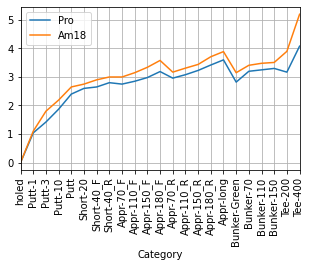

In [69]:
cats, inx = make_category_index()
p = sgdf.plot.line(y=['Pro', 'Am18'], grid=True, rot=90, xticks=inx, figsize=(5,3))
p.set_xticklabels(cats);

p

The gap between the two lines visualizes the proficiency difference between a PGA tour pro and a 18-handicap. The values for the 18-hcp are a result of some educated guesswork and measuring my own performance (as an 18-hcp).

For different handicaps, our task will be to interpolate between (or extrapolate) the two curves. Let's define an interpolations function as a helper.

In [22]:
def interp(f, intv):
    return f*(intv[1]-intv[0])+intv[0]

print("1/3[1,2] = %.2f" % interp(1/3, (1, 2)))

1/3[1,2] = 1.33


Now we're able to calculate a strokes-gained target for a given category and handicap.

In [23]:
def hcp_sg(hcp, cat):
    cat_row = sgdf.loc[cat]
    sg = interp(hcp/18, (cat_row['Pro'], cat_row['Am18']))
    #print(cat_row)
    return sg

print("Hcp 18 target for short game      = %.2f" % hcp_sg(18, 'Short-20'))
print("Hcp 10 target for long approaches = %.2f" % hcp_sg(10, 'Appr-long'))

Hcp 18 target for short game      = 2.75
Hcp 10 target for long approaches = 3.76


Tee-shots are only slightly more complicated.

In [24]:
def teeshot_sg(hcp, distance):
    t200 = hcp_sg(hcp, 'Tee-200')
    t400 = hcp_sg(hcp, 'Tee-400')
    #print("%.2f / %.2f" % (t200, t400))
    return interp((distance-200)/200, (t200, t400))

#print(teeshot_sg(0, 400))
#print(teeshot_sg(0, 300))
#print(teeshot_sg(18, 400))
#print(teeshot_sg(18, 366))

Now we include columns for SG-0 and SG-18 in our data frame.

In [25]:
def insert_SG_for_hcps(hcp, df):
    def local_sg(row):
        cat = row['sg_cat_from']
        mysg = hcp_sg(hcp, cat)
        if cat == 'tee-200' or cat == 'Tee-400':
            #print("interpolating SG for tee shot")
            mysg = teeshot_sg(hcp, row['from2pin'])
        #print("my sg = %.2f" % mysg)
        result_sg = hcp_sg(hcp, row['sg_cat_to'])
        #print("-> sg = %.2f" % result_sg)
        return mysg - result_sg - 1
    
    df['SG-'+str(hcp)] = df.apply(local_sg, axis=1)
    #return local_sg(row)
    return df

#print(df.iloc[0])
#print("\nstrokes gained for tee shot = %.2f" % sg_for_hcp(12, df.iloc[0]))

df = insert_SG_for_hcps(0, df)
df = insert_SG_for_hcps(18, df)
df.head()

,round,hole,stroke,lie,result,from2pin,to2pin,dist,par,sg_cat_from,sg_cat_to,SG-0,SG-18
0,2020-10-01,1,1,T,F,365.297857,146.940086,218.357771,4,Tee-400,Appr-150_F,-0.057895,0.634436
1,2020-10-01,1,2,F,F,146.940086,14.608125,132.331961,4,Appr-150_F,Short-20,-0.620000,-0.410000
2,2020-10-01,1,3,F,G,14.608125,1.864779,12.743345,4,Short-20,Putt-3,0.180000,-0.050000
3,2020-10-01,1,4,G,H,1.864779,0.000000,1.864779,4,Putt-3,holed,0.420000,0.800000
4,2020-10-01,2,1,T,F,119.332876,23.106897,96.225979,3,Tee-200,Short-40_F,-0.480000,0.000000


Finally, we need to fix one small thing: For analytical purposes tee-shots for par-3s fall into shot categories of approach shots from the fairway.

In [26]:
def fix_teeshot_cat(row):
    cat_from = row['sg_cat_from']
    if row['lie'] == "T" and row['par'] == 3:
        row['lie'] = "F"
        cat_from = cat_sg(row, 'from2pin', 'lie')
        print(cat_from)
    return cat_from


df['sg_category'] = df.apply(fix_teeshot_cat, axis=1)
df.head()

Appr-150_F


,round,hole,stroke,lie,result,from2pin,to2pin,dist,par,sg_cat_from,sg_cat_to,SG-0,SG-18,sg_category
0,2020-10-01,1,1,T,F,365.297857,146.940086,218.357771,4,Tee-400,Appr-150_F,-0.057895,0.634436,Tee-400
1,2020-10-01,1,2,F,F,146.940086,14.608125,132.331961,4,Appr-150_F,Short-20,-0.620000,-0.410000,Appr-150_F
2,2020-10-01,1,3,F,G,14.608125,1.864779,12.743345,4,Short-20,Putt-3,0.180000,-0.050000,Short-20
3,2020-10-01,1,4,G,H,1.864779,0.000000,1.864779,4,Putt-3,holed,0.420000,0.800000,Putt-3
4,2020-10-01,2,1,T,F,119.332876,23.106897,96.225979,3,Tee-200,Short-40_F,-0.480000,0.000000,Appr-150_F


## Preparing Summaries <a name="summaries"></a>
(<a href="#toc">back to ToC</a>)

Taking a look at individual shots is great, but users need summary information on what to work on with their game.



### Per Category Summaries <a name="catsummaries"></a>
(<a href="#toc">back to ToC</a>)

First we extract a condensed data frame.

In [27]:
dfx = df[['sg_category', 'SG-0', 'SG-18']]
dfx.head()

,sg_category,SG-0,SG-18
0,Tee-400,-0.057895,0.634436
1,Appr-150_F,-0.620000,-0.410000
2,Short-20,0.180000,-0.050000
3,Putt-3,0.420000,0.800000
4,Appr-150_F,-0.480000,0.000000


The first statistic of interest will be the mean SG-value for every shot category. *pivot_table*( ) uses mean-aggregation by default. 

In [28]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

#df_sg_means = dfx.pivot(columns='sg_category', values=['SG-0', 'SG-18']).mean()
df_sg_means = pd.pivot_table(dfx, index='sg_category')

df_sg_means.head()

,SG-0,SG-18
sg_category,,
Appr-150_F,-0.550000,-0.205000
Putt-3,0.420000,0.800000
Short-20,0.890000,0.850000
Short-40_F,-0.950000,-0.850000
Tee-400,-0.057895,0.634436


In [29]:
m0 = df_sg_means  #['SG-0']
m0 = m0.reindex(cats).drop(['holed', 'Tee-200'])
SG_details_table = pd.DataFrame(m0)
#SG_details_table.columns = ["SG"]
SG_details_table.head()

,SG-0,SG-18
sg_category,,
Putt-1,NaN,NaN
Putt-3,0.42,0.80
Putt-10,NaN,NaN
Putt,NaN,NaN
Short-20,0.89,0.85


In [30]:
SG_details_table['label'] = SG_details_table.apply(lambda row: sg_official[row.name], axis=1)

SG_details_table.head()

,SG-0,SG-18,label
sg_category,,,
Putt-1,NaN,NaN,Putt ≤ 1m
Putt-3,0.42,0.80,Putt ≤ 3m
Putt-10,NaN,NaN,Putt ≤ 10m
Putt,NaN,NaN,Distance Putt
Short-20,0.89,0.85,Around Green ≤ 20m


For HTML output we need a way to iterate over rows by means of the Jinja template engine.

In [31]:
SG_details_table.to_dict(orient='records')[0:5]  # create an ordered list of dicts, iteratable

[{'SG-0': nan, 'SG-18': nan, 'label': 'Putt ≤ 1m'},
 {'SG-0': 0.41999999999999993, 'SG-18': 0.8, 'label': 'Putt ≤ 3m'},
 {'SG-0': nan, 'SG-18': nan, 'label': 'Putt ≤ 10m'},
 {'SG-0': nan, 'SG-18': nan, 'label': 'Distance Putt'},
 {'SG-0': 0.8900000000000001, 'SG-18': 0.85, 'label': 'Around Green ≤ 20m'}]

### Category Groups <a name="catgroups"></a>
(<a href="#toc">back to ToC</a>)

The PGA clusters strokes gained categories into clusters for easier communication.

In [32]:
category_groups = {
    "holed": '',
    "Putt-1": 'Putting',
    "Putt-3": 'Putting',
    "Putt-10": 'Putting',
    "Putt": 'Putting',
    "Short-20": 'Around the Green',
    "Short-40_F": 'Around the Green',
    "Short-40_R": 'Around the Green',
    "Appr-70_F": 'Approach',
    "Appr-110_F": 'Approach',
    "Appr-150_F": 'Approach',
    "Appr-180_F": 'Approach',
    "Appr-70_R": 'Approach',
    "Appr-110_R": 'Approach',
    "Appr-150_R": 'Approach',
    "Appr-180_R": 'Approach',
    "Appr-long": 'Approach',
    "Bunker-Green": 'Around the Green',
    "Bunker-70": 'Around the Green',
    "Bunker-110": 'Approach',
    "Bunker-150": 'Approach',
    "Tee-200": '',
    "Tee-400": 'Driving'
}

cat_group_names = ["Putting","Around the Green","Approach","Driving"]

We attach the category group label to each row / shot.

In [33]:
df['cat_group'] = df['sg_category'].apply(lambda x: category_groups[x]).astype("category")
df['cat_group'].cat.set_categories(cat_group_names,inplace=True)
dfy = df[['cat_group', 'SG-0', 'SG-18']]

dfy.head()

,cat_group,SG-0,SG-18
0,Driving,-0.057895,0.634436
1,Approach,-0.620000,-0.410000
2,Around the Green,0.180000,-0.050000
3,Putting,0.420000,0.800000
4,Approach,-0.480000,0.000000


Now we're ready to aggregate SG statistics per category group.

In [34]:
group_SG_stats = pd.pivot_table(dfy, index='cat_group')

group_SG_stats.head()

,SG-0,SG-18
cat_group,,
Putting,0.420000,0.800000
Around the Green,0.276667,0.283333
Approach,-0.550000,-0.205000
Driving,-0.057895,0.634436


As explained above Jinja templates must be able to iterate over the table.

In [35]:
group_SG_stats['group_name'] = group_SG_stats.index  #cat_group_names

group_SG_stats.to_dict(orient='records')

[{'SG-0': 0.41999999999999993, 'SG-18': 0.8, 'group_name': 'Putting'},
 {'SG-0': 0.27666666666666667,
  'SG-18': 0.28333333333333327,
  'group_name': 'Around the Green'},
 {'SG-0': -0.55, 'SG-18': -0.20500000000000007, 'group_name': 'Approach'},
 {'SG-0': -0.057894752154709295,
  'SG-18': 0.6344360683504151,
  'group_name': 'Driving'}]

### Classic Statistics <a name="classics"></a>
(<a href="#toc">back to ToC</a>)

**Driving Distance** is defined by Mark Broadie as the 75th percentile of all non-par-3 tee shots. We will be a bit more optimistic and use the 80th percentile.

In [36]:
drives = df[['sg_category', 'dist']].where(df['sg_category'] == 'Tee-400', axis=0)
driving_distance = drives.quantile(.8, axis=0)

print(type(driving_distance[0]))
print("Driving Distance = %.2f" % driving_distance[0])

<class 'numpy.float64'>
Driving Distance = 218.36


Another classic is **Greens in Regulation**. This is a bit more involved.

First filter for shots to the green or into the hole.

In [37]:
greens = df[['round', 'hole', 'stroke', 'par', 'result']]
ongreen = greens['result']=="G"
inhole  = greens['result']=="H" # include hole-in-ones and eagles
greens = greens.where(ongreen | inhole)

greens.loc[greens['stroke'].notna()].head(3)

,round,hole,stroke,par,result
2,2020-10-01,1,3.0,4.0,G
3,2020-10-01,1,4.0,4.0,H
6,2020-10-01,2,3.0,3.0,H


We group by (round, hole) and take the shot with the lowest stroke number (= *np.min*). This gives us the first shot per hole to land on the green (or in the hole). In the next step we can compare this shot to par.

In [38]:
gir = pd.pivot_table(greens, index=['round', 'hole'], values=['stroke', 'par'], aggfunc=np.min)

gir['stroke'] = gir['stroke'].astype(int)
gir['par']    = gir['par'].astype(int)
print(gir.dtypes)
gir.head(3)

par       int64
stroke    int64
dtype: object


par  stroke
round      hole             
2020-10-01 1       4       3
           2       3       3

Now we introduce the *GiR* metric. It is >= 0 for a "Green in Regulation" and negativ otherwise.

In [39]:
gir['GiR'] = gir['par'] - gir['stroke'] - 2
gir = gir.drop(['stroke'], axis=1)

gir.head()

par  GiR
round      hole          
2020-10-01 1       4   -1
           2       3   -2

As usual we want to be able to export it as a dict for the UI. This is intended for an overview of a round of golf, flagging GiR per hole.

In [40]:
gir['hole'] = gir.index
gir.to_dict(orient='records')

[{'par': 4, 'GiR': -1, 'hole': ('2020-10-01', '1')},
 {'par': 3, 'GiR': -2, 'hole': ('2020-10-01', '2')}]

We're left with one small task: calculate the overall percentage for GiR.

In [41]:
GiR_percentage = len(gir[gir['GiR'] >= 0].index)/(len(gir.index))*100.0

print("Overall GiR = %.2f %%" % GiR_percentage)

Overall GiR = 0.00 %


The last classic statistic we'll calulate is **Fairways hit**.

In [42]:
fw = df[['round', 'hole', 'stroke', 'sg_category', 'result']]
onfw  = fw['result']=="F"
istee = fw['sg_category']=="Tee-400"

fw = fw.where(istee)
teeshot_count = len(fw.loc[fw['result'].notna()])
fw = fw.where(onfw)
fw_count = len(fw.loc[fw['result'].notna()])
fw_hit = fw_count/teeshot_count*100.0

print("Overall count of long tee-shots = %d" % teeshot_count)
print("Overall FW = %.2f %%" % fw_hit)
fw.loc[fw['result'].notna()].head(3)
      

Overall count of long tee-shots = 1
Overall FW = 100.00 %


,round,hole,stroke,sg_category,result
0,2020-10-01,1,1.0,Tee-400,F


Now let's construct a table showing all the non-par-3 holes where the *1st* tee shot ended up on the fairway. We have to eliminate all tee shots with s shot index > 1. The data could include tee shots e.g. as 3rd shots (onto the fairway) after the first tee shot ended up OB (resulting in 2 tee shots for the same hole). We count these "reloaded" shots for our overall statistics, as they help us asses our driving capabilities, but we won't display them for course summaries.

In [43]:
fw = fw.where(fw['stroke']< 1.5) # eliminate tee-shots after first one has been a miss
fw = fw[['round', 'hole', 'result']]

fw = fw.loc[fw['result'].notna()] # finally drop NaNs

fw.head(3)

,round,hole,result
0,2020-10-01,1,F


As usual we want to be able to export it as a dict for the UI. This is intended for an overview of a round of golf, flagging *Fairways hit* per hole.

In [44]:
fw.to_dict(orient='records')

[{'round': '2020-10-01', 'hole': '1', 'result': 'F'}]

This is a function to calculate all the classic statistics in one go. There is nothing new here, just collecting the code snippets above.

In [45]:
def classic_stats(df):
    drives = df[['sg_category', 'dist']].where(df['sg_category'] == 'Tee-400', axis=0)
    driving_distance = drives.quantile(.8, axis=0)[0]
    
    greens = df[['round', 'hole', 'stroke', 'par', 'result']]
    ongreen = greens['result']=="G"
    inhole  = greens['result']=="H"
    greens = greens.where(ongreen | inhole)    
    gir = pd.pivot_table(greens, index=['round', 'hole'], values=['stroke', 'par'], aggfunc=np.min)
    gir['GiR'] = gir['par'] - gir['stroke'] - 2
    gir = gir.drop(['stroke'], axis=1)
    gir['hole'] = gir.index
    gir_dict = gir.to_dict(orient='records')
    GiR_percentage = len(gir[gir['GiR'] >= 0].index)/(len(gir.index))*100.0
    
    fw = df[['round', 'hole', 'stroke', 'sg_category', 'result']]
    onfw  = fw['result']=="F"
    istee = fw['sg_category']=="Tee-400"
    fw = fw.where(istee)
    teeshot_count = len(fw.loc[fw['result'].notna()])
    fw = fw.where(onfw)
    fw_count = len(fw.loc[fw['result'].notna()])
    fw_hit = fw_count/teeshot_count*100.0
    fw = fw.where(fw['stroke']< 1.5)
    fw = fw[['round', 'hole', 'result']]
    fw = fw.loc[fw['result'].notna()]
    fw_dict = fw.to_dict(orient='records')

    stats = {
        'driving_distance': driving_distance,
        'GiR': gir_dict,
        'GiR_pcnt': GiR_percentage,
        'FW_hit': fw_dict,
        'FW_pcnt': fw_hit
    }
    return stats

classic_stats(df)


{'driving_distance': 218.3577709215127,
 'GiR': [{'par': 4.0, 'GiR': -1.0, 'hole': ('2020-10-01', '1')},
  {'par': 3.0, 'GiR': -2.0, 'hole': ('2020-10-01', '2')}],
 'GiR_pcnt': 0.0,
 'FW_hit': [{'round': '2020-10-01', 'hole': '1', 'result': 'F'}],
 'FW_pcnt': 100.0}

In [46]:
h = df.loc[df['result']=="H"][['hole','par','stroke']]
h = pd.pivot_table(h, index=["par"])
h['par'] = h.index
h.to_dict(orient="record")

[{'stroke': 3, 'par': 3}, {'stroke': 4, 'par': 4}]